In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary 

## Step 1: Load the housing price dataset from sklearn

In [17]:
# fetching califonia housing price dataset
california = fetch_california_housing()
X = california.data
y = california.target
print("California housing dataset loaded.")
print("Feature shape:", X_california.shape)
print("Target shape:", y_california.shape)
print("Feature names:", california.feature_names)

California housing dataset loaded.
Feature shape: (20640, 8)
Target shape: (20640,)
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [78]:
# Feature explanations for California Housing dataset:
# MedInc    : Median income in the area (in tens of thousands of dollars)
# HouseAge  : Average age of the houses in the area (in years)
# AveRooms  : Average number of rooms per household
# AveBedrms : Average number of bedrooms per household
# Population: Total population in the area
# AveOccup  : Average number of occupants per household
# Latitude  : Geographic latitude of the area
# Longitude : Geographic longitude of the area

# Target variable explanation:
# Target    : Median house value for households within the area (in units of 100,000 dollars)

# showcase the dataset
df = pd.DataFrame(X_california, columns=california.feature_names)
df['Target'] = y_california
df.to_csv("housing_price_california.csv")
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Step 2: Prepare input data for model training

In [18]:
# Standardize features (important for NN training)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert numpy arrays to torch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # target shape: (N,1)

# Create dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split into train/val/test sets (70% train, 15% val, 15% test)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Step 3: Model Build: Two-layer MLP

In [40]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)  # regression output
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = X.shape[1]  # 8 features
hidden_dim = 64         # can tune this

model = SimpleMLP(input_dim, hidden_dim)

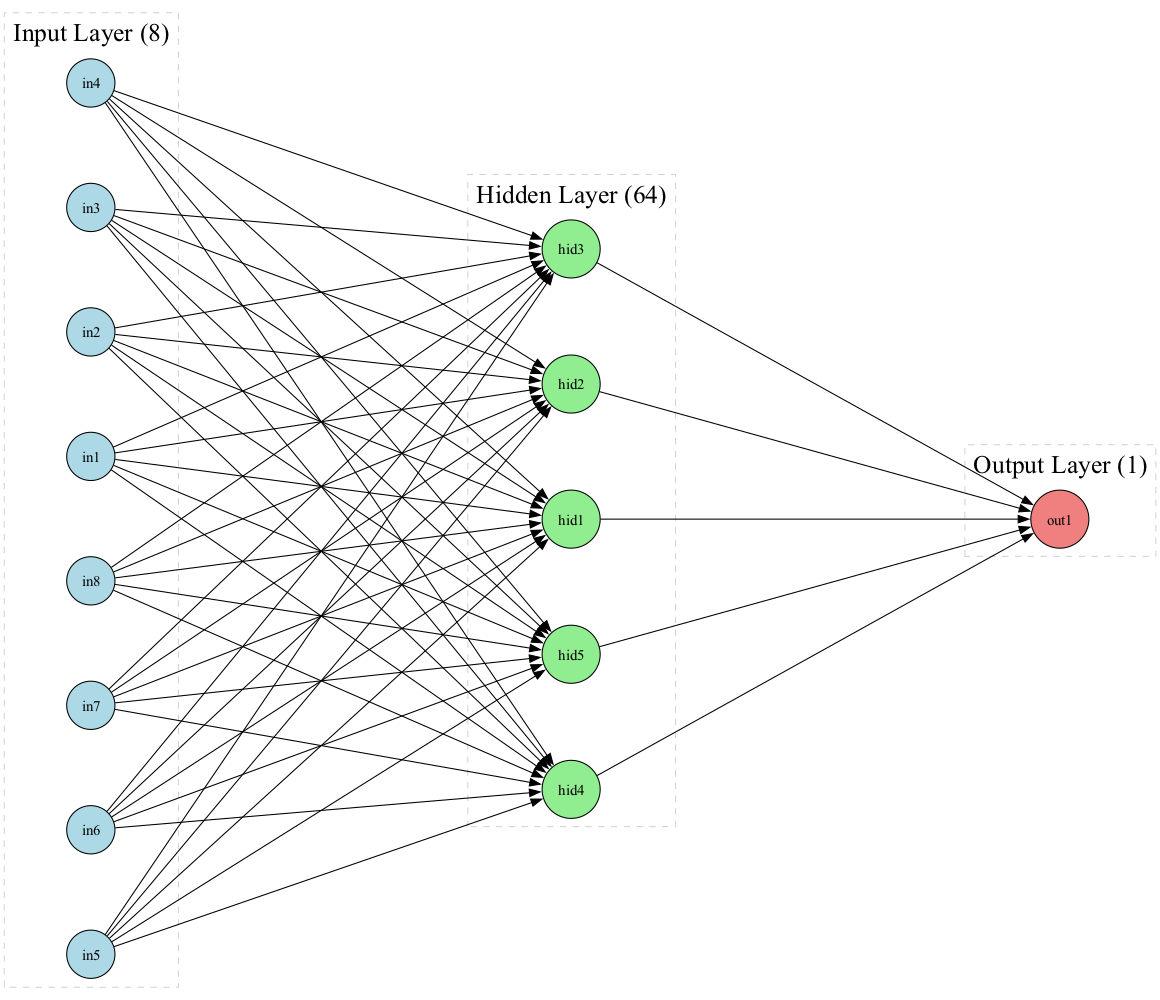

In [80]:
# Visualizing the model architecture (move to helper function later)

import pygraphviz as pgv
from IPython.display import Image


def draw_simple_mlp():
    G = pgv.AGraph(strict=False, directed=True)

    # Input layer (8 nodes)
    input_nodes = [f'in{i+1}' for i in range(8)]
    for node in input_nodes:
        G.add_node(node, shape='circle', style='filled', fillcolor='lightblue')

    # Hidden layer (5 nodes for display; real model uses 64)
    hidden_nodes = [f'hid{i+1}' for i in range(5)]
    for node in hidden_nodes:
        G.add_node(node, shape='circle', style='filled', fillcolor='lightgreen')

    # Output layer (1 node)
    output_node = 'out1'
    G.add_node(output_node, shape='circle', style='filled', fillcolor='lightcoral')

    # Edges: input -> hidden
    for i_node in input_nodes:
        for h_node in hidden_nodes:
            G.add_edge(i_node, h_node)

    # Edges: hidden -> output
    for h_node in hidden_nodes:
        G.add_edge(h_node, output_node)

    # Subgraphs with labels for layer captions
    with G.subgraph(name='cluster_input') as c:
        c.add_nodes_from(input_nodes)
        c.graph_attr.update(label='Input Layer (8)', color='lightgrey', style='dashed')
        c.graph_attr.update(rank='same')

    with G.subgraph(name='cluster_hidden') as c:
        c.add_nodes_from(hidden_nodes)
        c.graph_attr.update(label='Hidden Layer (64)', color='lightgrey', style='dashed')
        c.graph_attr.update(rank='same')

    with G.subgraph(name='cluster_output') as c:
        c.add_node(output_node)
        c.graph_attr.update(label='Output Layer (1)', color='lightgrey', style='dashed')
        c.graph_attr.update(rank='same')

    # Graph layout settings
    G.graph_attr.update(
        rankdir='LR',
        size='30,10!',
        dpi='100',
        nodesep='1.0',
        ranksep='4.0',
        fontsize='24',
        splines='line'
    )

    G.draw('simple_mlp.png', prog='dot')
    return Image('simple_mlp.png')

draw_simple_mlp()

In [ ]:
# # Visualize model structure using torchsummary
# print("Model summary:")
# summary(model, input_size=(input_dim,))

## Step 4: Model Training

In [81]:
# Training Setup
learning_rate = 0.001  # step size for optimizer
num_epochs = 50        # number of passes over entire dataset
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
# Training Loop with Validation
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * features.size(0)
    train_loss = running_loss / train_size
    train_losses.append(train_loss)
    
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_features, val_targets in val_loader:
            val_outputs = model(val_features)
            val_loss = criterion(val_outputs, val_targets)
            val_running_loss += val_loss.item() * val_features.size(0)
    val_loss_epoch = val_running_loss / val_size
    val_losses.append(val_loss_epoch)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss_epoch:.4f}")

Epoch [1/50] - Train Loss: 1.5828, Val Loss: 0.7992
Epoch [2/50] - Train Loss: 0.6625, Val Loss: 0.6143
Epoch [3/50] - Train Loss: 0.5294, Val Loss: 0.5050
Epoch [4/50] - Train Loss: 0.4653, Val Loss: 0.4523
Epoch [5/50] - Train Loss: 0.4338, Val Loss: 0.4235
Epoch [6/50] - Train Loss: 0.4196, Val Loss: 0.4116
Epoch [7/50] - Train Loss: 0.4080, Val Loss: 0.4009
Epoch [8/50] - Train Loss: 0.3993, Val Loss: 0.3898
Epoch [9/50] - Train Loss: 0.3936, Val Loss: 0.3902
Epoch [10/50] - Train Loss: 0.3882, Val Loss: 0.3805
Epoch [11/50] - Train Loss: 0.3840, Val Loss: 0.3784
Epoch [12/50] - Train Loss: 0.3782, Val Loss: 0.3658
Epoch [13/50] - Train Loss: 0.3762, Val Loss: 0.3756
Epoch [14/50] - Train Loss: 0.3731, Val Loss: 0.3621
Epoch [15/50] - Train Loss: 0.3722, Val Loss: 0.3802
Epoch [16/50] - Train Loss: 0.3693, Val Loss: 0.3562
Epoch [17/50] - Train Loss: 0.3632, Val Loss: 0.3538
Epoch [18/50] - Train Loss: 0.3628, Val Loss: 0.3480
Epoch [19/50] - Train Loss: 0.3518, Val Loss: 0.3422
Ep

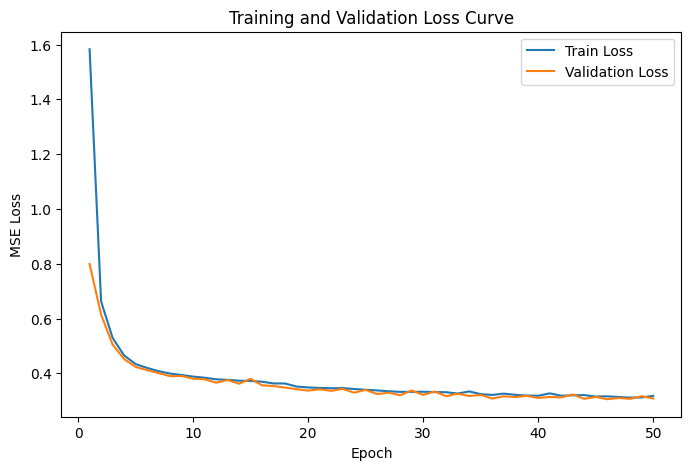

In [23]:
# Plot Training and Validation Loss
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.show()

## Step 5: Test Model Performance

In [26]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def evaluate_regression_model(model, loader, show_examples=False):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in loader:
            outputs = model(features)
            all_preds.append(outputs.cpu())
            all_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    mse = mean_squared_error(all_labels, all_preds)
    rmse = mse ** 0.5
    r2 = r2_score(all_labels, all_preds)
    
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R^2 Score: {r2:.4f}")
    
    if show_examples:
        plt.figure(figsize=(6,6))
        plt.scatter(all_labels, all_preds, alpha=0.5)
        plt.plot([all_labels.min(), all_labels.max()], [all_labels.min(), all_labels.max()], 'r--')
        plt.xlabel("Actual Median House Value")
        plt.ylabel("Predicted Median House Value")
        plt.title("Predicted vs Actual on Test Set")
        plt.show()

Test RMSE: 0.5553
Test R^2 Score: 0.7687


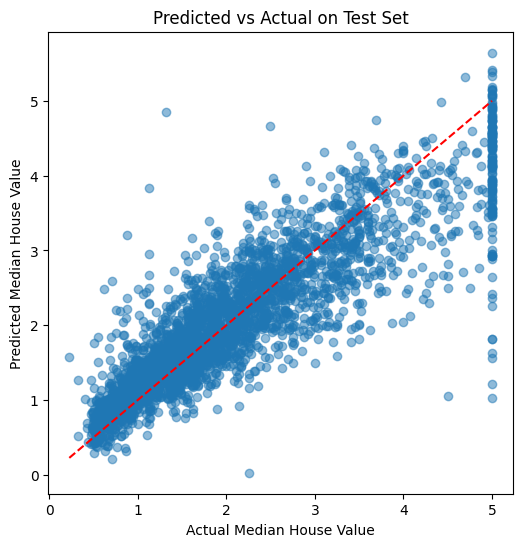

In [27]:
evaluate_regression_model(model, test_loader, show_examples=True)